In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import os
import sys
import pickle

print("✓ Librerie importate")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponibile: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✓ Librerie importate
PyTorch version: 2.7.1+cu118
Device disponibile: cuda


## 2. DATA LOADING

In [12]:
# ===== CONFIGURAZIONE =====
# Seleziona l'appliance da disaggregare
# Appliances disponibili:
# - chargingstation_socket, dishwasher, dryer, garagecabinet
# - heatpump, heatpump_controller, oven, rainwaterpump
# - rangehood, smappeecharger, stove, washingmachine

TARGET_APPLIANCE = 'heatpump'  # Cambia qui per selezionare un'altra appliance

# Percorso base dei dati
DATA_BASE_PATH = os.path.join("..", "data", "processed", "15min", "model_ready")
APPLIANCE_PATH = os.path.join(DATA_BASE_PATH, TARGET_APPLIANCE)

# Lista delle appliances disponibili
available_appliances = [d for d in os.listdir(DATA_BASE_PATH) 
                        if os.path.isdir(os.path.join(DATA_BASE_PATH, d))]
print(f"Appliances disponibili: {available_appliances}")

# Verifica che l'appliance selezionata esista
assert TARGET_APPLIANCE in available_appliances, f"Appliance '{TARGET_APPLIANCE}' non trovata!"

# Carica i dati preprocessati
X_train = np.load(os.path.join(APPLIANCE_PATH, "X_train.npy"))
X_val = np.load(os.path.join(APPLIANCE_PATH, "X_val.npy"))
X_test = np.load(os.path.join(APPLIANCE_PATH, "X_test.npy"))
y_train = np.load(os.path.join(APPLIANCE_PATH, "y_train.npy"))
y_val = np.load(os.path.join(APPLIANCE_PATH, "y_val.npy"))
y_test = np.load(os.path.join(APPLIANCE_PATH, "y_test.npy"))

# Carica lo scaler se disponibile
scaler_path = os.path.join(DATA_BASE_PATH, "scaler.pkl")
if os.path.exists(scaler_path):
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    print(f"✓ Scaler caricato da {scaler_path}")
else:
    scaler = None
    print("⚠️ Scaler non trovato, i dati potrebbero già essere normalizzati")

print(f"\n✓ Dataset '{TARGET_APPLIANCE}' caricato:")
print(f"  X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape} | y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape} | y_test:  {y_test.shape}")

# Determina parametri dai dati
# X shape: (samples, seq_len, num_features)
# y shape: (samples, seq_len, 1)
window_size = X_train.shape[1]  # 99 timesteps
num_input_features = X_train.shape[2]  # 7 features

print(f"\n✓ Window size: {window_size} timesteps")
print(f"✓ Input features: {num_input_features}")

Appliances disponibili: ['chargingstation_socket', 'dishwasher', 'dryer', 'garagecabinet', 'heatpump', 'heatpump_controller', 'oven', 'rainwaterpump', 'rangehood', 'smappeecharger', 'stove', 'washingmachine']
✓ Scaler caricato da ..\data\processed\15min\model_ready\scaler.pkl

✓ Dataset 'heatpump' caricato:
  X_train: (24094, 99, 7) | y_train: (24094, 99, 1)
  X_val:   (5374, 99, 7) | y_val:   (5374, 99, 1)
  X_test:  (5278, 99, 7) | y_test:  (5278, 99, 1)

✓ Window size: 99 timesteps
✓ Input features: 7


## 3. EXPLORATORY DATA ANALYSIS

In [13]:
# Analizza i dati caricati
print("=== STATISTICHE DATASET ===")
print(f"\n📊 Input (X) - {num_input_features} features:")
print(f"  Train: min={X_train.min():.4f}, max={X_train.max():.4f}, mean={X_train.mean():.4f}")
print(f"  Val:   min={X_val.min():.4f}, max={X_val.max():.4f}, mean={X_val.mean():.4f}")
print(f"  Test:  min={X_test.min():.4f}, max={X_test.max():.4f}, mean={X_test.mean():.4f}")

print(f"\n📊 Statistiche per feature (X_train):")
for i in range(num_input_features):
    feat_data = X_train[:, :, i]
    print(f"  Feature {i}: min={feat_data.min():.4f}, max={feat_data.max():.4f}, mean={feat_data.mean():.4f}")

print(f"\n📊 Target (y - {TARGET_APPLIANCE}):")
print(f"  Train: min={y_train.min():.4f}, max={y_train.max():.4f}, mean={y_train.mean():.4f}")
print(f"  Val:   min={y_val.min():.4f}, max={y_val.max():.4f}, mean={y_val.mean():.4f}")
print(f"  Test:  min={y_test.min():.4f}, max={y_test.max():.4f}, mean={y_test.mean():.4f}")

print(f"\n📊 Dimensioni:")
print(f"  Sequenze totali: {len(X_train) + len(X_val) + len(X_test)}")
print(f"  Train: {len(X_train)} ({len(X_train)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
print(f"  Val:   {len(X_val)} ({len(X_val)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
print(f"  Test:  {len(X_test)} ({len(X_test)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")

=== STATISTICHE DATASET ===

📊 Input (X) - 7 features:
  Train: min=0.0000, max=1.0000, mean=0.4376
  Val:   min=0.0000, max=1.0000, mean=0.4455
  Test:  min=0.0000, max=1.0000, mean=0.4468

📊 Statistiche per feature (X_train):
  Feature 0: min=0.0000, max=1.0000, mean=0.1040
  Feature 1: min=0.0000, max=1.0000, mean=0.5000
  Feature 2: min=0.0000, max=1.0000, mean=0.5000
  Feature 3: min=0.0000, max=1.0000, mean=0.5018
  Feature 4: min=0.0000, max=1.0000, mean=0.4734
  Feature 5: min=0.0000, max=1.0000, mean=0.4841
  Feature 6: min=0.0000, max=1.0000, mean=0.4999

📊 Target (y - heatpump):
  Train: min=0.0000, max=1.0000, mean=0.1152
  Val:   min=0.0006, max=0.9938, mean=0.1375
  Test:  min=0.0006, max=0.9986, mean=0.1376

📊 Dimensioni:
  Sequenze totali: 34746
  Train: 24094 (69.3%)
  Val:   5374 (15.5%)
  Test:  5278 (15.2%)


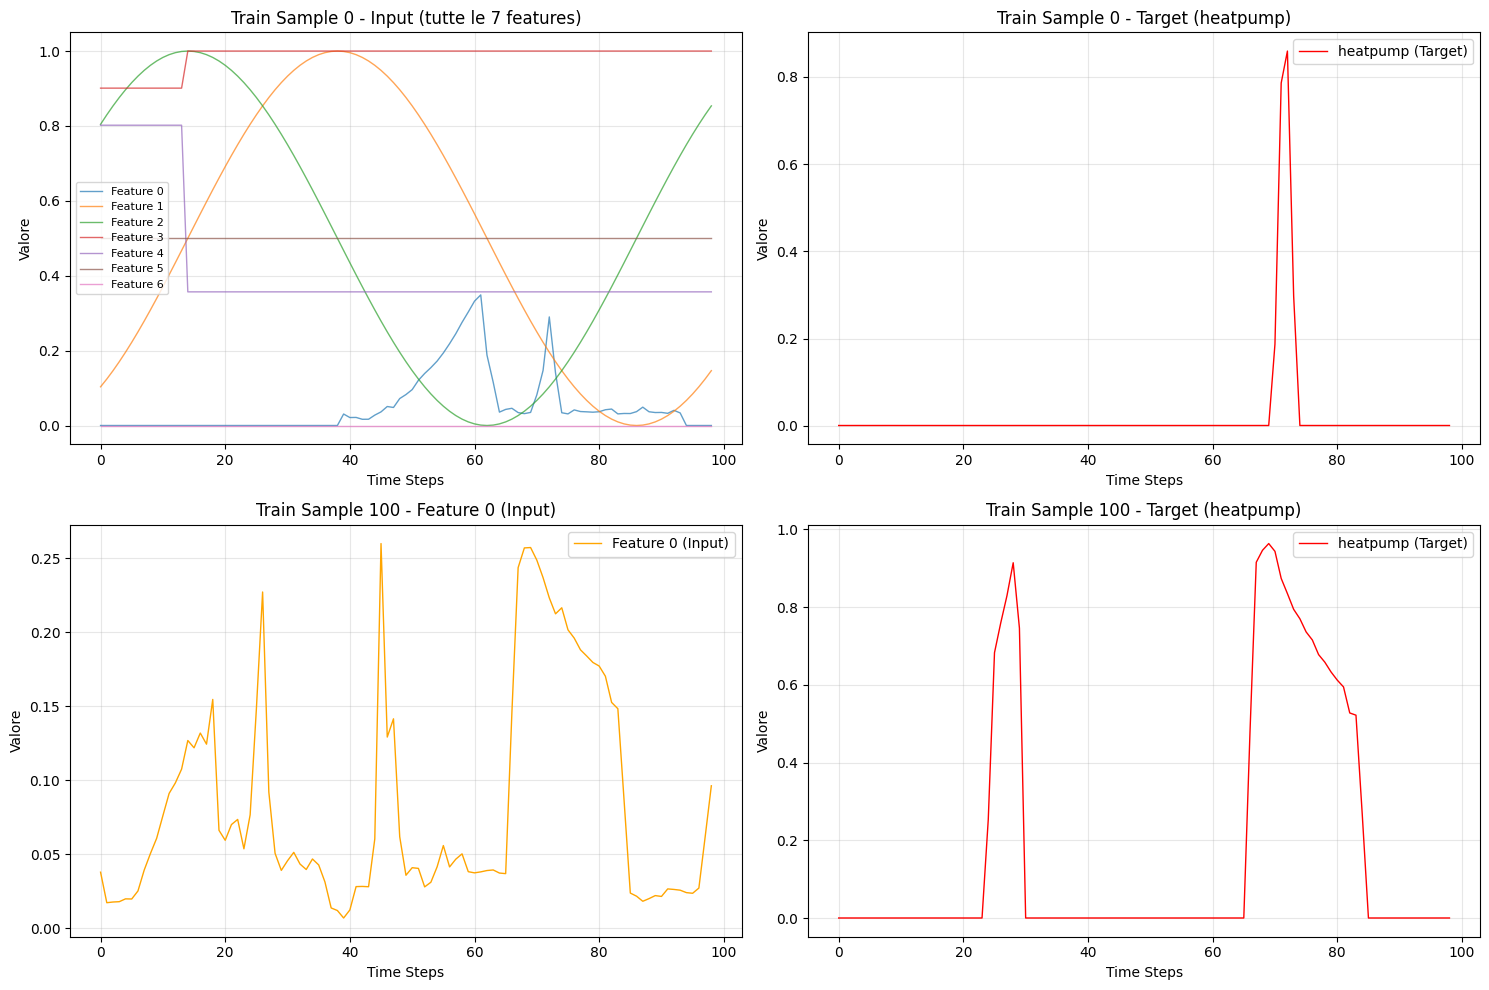

In [14]:
# Visualizza alcune sequenze di esempio
sample_idx = 0

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot di tutte le features di input per il primo sample
ax = axes[0, 0]
for i in range(num_input_features):
    ax.plot(X_train[sample_idx, :, i], linewidth=1, label=f'Feature {i}', alpha=0.7)
ax.set_title(f'Train Sample {sample_idx} - Input (tutte le {num_input_features} features)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Valore')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

# Target per il primo sample
ax = axes[0, 1]
ax.plot(y_train[sample_idx, :, 0], linewidth=1, color='red', label=f'{TARGET_APPLIANCE} (Target)')
ax.set_title(f'Train Sample {sample_idx} - Target ({TARGET_APPLIANCE})')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Valore')
ax.grid(True, alpha=0.3)
ax.legend()

# Seconda sequenza - solo feature 0 (assumendo sia l'aggregate principale)
sample_idx_2 = min(100, len(X_train)-1)
ax = axes[1, 0]
ax.plot(X_train[sample_idx_2, :, 0], linewidth=1, color='orange', label='Feature 0 (Input)')
ax.set_title(f'Train Sample {sample_idx_2} - Feature 0 (Input)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Valore')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1, 1]
ax.plot(y_train[sample_idx_2, :, 0], linewidth=1, color='red', label=f'{TARGET_APPLIANCE} (Target)')
ax.set_title(f'Train Sample {sample_idx_2} - Target ({TARGET_APPLIANCE})')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Valore')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 4. DATA NORMALIZATION & SEQUENCE CREATION

In [15]:
# I dati sono già preprocessati e pronti per il training
# Shape: X -> (samples, seq_len, num_features), y -> (samples, seq_len, 1)

print(f"✓ Dati pronti per il training")
print(f"  X_train shape: {X_train.shape} -> (samples, seq_len={window_size}, features={num_input_features})")
print(f"  y_train shape: {y_train.shape} -> (samples, seq_len={window_size}, target=1)")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_val shape: {y_val.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

✓ Dati pronti per il training
  X_train shape: (24094, 99, 7) -> (samples, seq_len=99, features=7)
  y_train shape: (24094, 99, 1) -> (samples, seq_len=99, target=1)
  X_val shape: (5374, 99, 7)
  y_val shape: (5374, 99, 1)
  X_test shape: (5278, 99, 7)
  y_test shape: (5278, 99, 1)


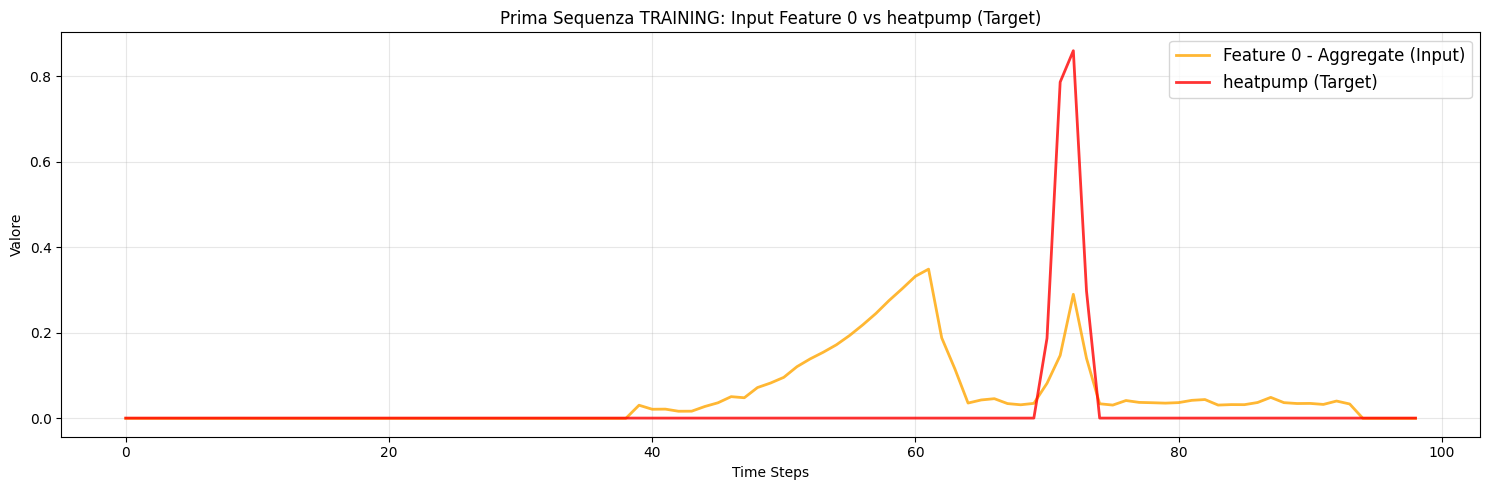

In [16]:
# Visualizza il confronto Input vs Target per la prima sequenza di TRAINING
plt.figure(figsize=(15, 5))
# Plot feature 0 (assumendo sia l'aggregate/consumo totale)
plt.plot(range(window_size), X_train[0, :, 0], linewidth=2, color='orange', label='Feature 0 - Aggregate (Input)', alpha=0.8)
plt.plot(range(window_size), y_train[0, :, 0], linewidth=2, color='red', label=f'{TARGET_APPLIANCE} (Target)', alpha=0.8)
plt.xlabel('Time Steps')
plt.ylabel('Valore')
plt.title(f'Prima Sequenza TRAINING: Input Feature 0 vs {TARGET_APPLIANCE} (Target)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. MODEL DEFINITION - CNN Seq2Seq

In [17]:
# Modello CNN Seq2Seq per NILM - adattato per multiple features di input

class CNNSeq2Seq(nn.Module):
    """
    CNN Seq2Seq per disaggregazione energetica.
    Architettura encoder-decoder con convoluzioni 1D.
    Supporta multiple features di input.
    """
    def __init__(self, input_channels=7, hidden_channels=48, num_layers=3):
        super(CNNSeq2Seq, self).__init__()
        
        # Encoder: estrae features dall'input
        encoder_layers = []
        in_ch = input_channels
        for i in range(num_layers):
            out_ch = hidden_channels * (2 ** i)
            encoder_layers.extend([
                nn.Conv1d(in_ch, out_ch, kernel_size=5, padding=2),
                nn.BatchNorm1d(out_ch),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.25)  # più regolarizzazione
            ])
            in_ch = out_ch
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Bottleneck
        self.bottleneck_ch = hidden_channels * (2 ** (num_layers - 1))
        
        # Decoder: ricostruisce il segnale dell'appliance
        decoder_layers = []
        in_ch = self.bottleneck_ch
        for i in range(num_layers - 1, -1, -1):
            out_ch = hidden_channels * (2 ** i) if i > 0 else hidden_channels
            decoder_layers.extend([
                nn.Conv1d(in_ch, out_ch, kernel_size=5, padding=2),
                nn.BatchNorm1d(out_ch),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.2)
            ])
            in_ch = out_ch
        self.decoder = nn.Sequential(*decoder_layers)
        
        # Output layer
        self.output_layer = nn.Sequential(
            nn.Conv1d(hidden_channels, 1, kernel_size=1),
            nn.ReLU()  # Output >= 0
        )
        
    def forward(self, x):
        # x: (batch, seq_len, num_features) -> (batch, num_features, seq_len)
        x = x.transpose(1, 2)
        
        # Encoder
        encoded = self.encoder(x)
        
        # Decoder
        decoded = self.decoder(encoded)
        
        # Output
        output = self.output_layer(decoded)
        
        # (batch, 1, seq_len) -> (batch, seq_len, 1)
        return output.transpose(1, 2)

print("✓ Modello CNN Seq2Seq definito")
print(f"  - Input channels: {num_input_features} features")
print("  - Architettura Encoder-Decoder")
print("  - LeakyReLU per gradient flow")
print("  - ReLU output (valori >= 0)")

✓ Modello CNN Seq2Seq definito
  - Input channels: 7 features
  - Architettura Encoder-Decoder
  - LeakyReLU per gradient flow
  - ReLU output (valori >= 0)


## 6. DATA PREPARATION FOR TRAINING

In [18]:
class EnergyDataset(Dataset):
    def __init__(self, X, y, augment=False, noise_std=0.01):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        self.augment = augment
        self.noise_std = noise_std
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment and self.noise_std > 0:
            noise = torch.randn_like(x) * self.noise_std
            x = torch.clamp(x + noise, 0.0, 1.0)
        return x, self.y[idx]

print("✓ EnergyDataset definito (opz. noise augmentation)")

✓ EnergyDataset definito (opz. noise augmentation)


## 7. TRAINING

In [19]:
# ===== CONFIGURAZIONE E TRAINING =====

batch_size = 32
hidden_channels = 64  # capacità ridotta
num_layers = 3  # Numero di layer encoder/decoder
num_epochs = 150
learning_rate = 0.0008
noise_std = 0.015  # rumore gaussiano sul train

# Dataset
train_dataset = EnergyDataset(X_train, y_train, augment=True, noise_std=noise_std)
val_dataset = EnergyDataset(X_val, y_val, augment=False)
test_dataset = EnergyDataset(X_test, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Sequenze TRAINING: {len(X_train):,}")
print(f"Sequenze VALIDATION: {len(X_val):,}")
print(f"Sequenze TEST: {len(X_test):,}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"Noise std (train only): {noise_std}")

# Setup modello CNN Seq2Seq
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNSeq2Seq(input_channels=num_input_features, hidden_channels=hidden_channels, num_layers=num_layers).to(device)
print(f"Parametri: {sum(p.numel() for p in model.parameters()):,}")
print(f"Input channels: {num_input_features}")

# === LOSS FUNCTION ===
class NILMLoss(nn.Module):
    """
    Loss per NILM con focus sui picchi.
    """
    def __init__(self, gamma=2.0, peak_weight=10.0):
        super(NILMLoss, self).__init__()
        self.gamma = gamma
        self.peak_weight = peak_weight
        
    def forward(self, pred, target):
        # MSE base
        mse = (pred - target) ** 2
        
        # Focal weighting: pesa di più gli errori dove il target è alto
        focal_weight = (target ** self.gamma) * self.peak_weight + 1.0
        
        # Loss pesata
        weighted_mse = (mse * focal_weight).mean()
        
        # Penalità per sotto-predizioni (quando target > pred)
        under_pred = torch.clamp(target - pred, min=0)
        under_pred_penalty = (under_pred ** 2 * focal_weight).mean()
        
        return weighted_mse + under_pred_penalty

criterion = NILMLoss(gamma=2.0, peak_weight=100.0)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=6, factor=0.5)

print("✓ NILMLoss configurata (focal-style per picchi)")
print("✓ ReduceLROnPlateau scheduler attivo")

Sequenze TRAINING: 24,094
Sequenze VALIDATION: 5,374
Sequenze TEST: 5,278
Device: GPU
Noise std (train only): 0.015
Parametri: 742,273
Input channels: 7
✓ NILMLoss configurata (focal-style per picchi)
✓ ReduceLROnPlateau scheduler attivo


In [ ]:
import time

# Training loop con validation
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience, patience_counter = 15, 0
lr_history = []

print(f"🚀 Training CNN Seq2Seq ({num_epochs} epoche, early stopping patience={patience})\n")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start = time.time()
    
    for inp, tgt in train_loader:
        inp, tgt = inp.to(device), tgt.to(device)
        
        pred = model(inp)
        loss = criterion(pred, tgt)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inp, tgt in val_loader:
            inp, tgt = inp.to(device), tgt.to(device)
            pred = model(inp)
            val_loss += criterion(pred, tgt).item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    # Early stopping basato su validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {current_lr:.6f} | {time.time()-start:.1f}s")
    
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(best_model_state)
print(f"\n✓ Training completato! Best validation loss: {best_val_loss:.6f}")

🚀 Training CNN Seq2Seq (150 epoche, early stopping patience=15)



## 8. RESULTS & VISUALIZATION

In [ ]:
# Plot training e validation loss
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(train_losses, label='Train Loss', color='blue')
axes[0].plot(val_losses, label='Validation Loss', color='orange')
axes[0].set_xlabel('Epoca')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning Rate
axes[1].plot(lr_history, linestyle='--', color='green', label='Learning Rate')
axes[1].set_xlabel('Epoca')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Train Loss: {train_losses[0]:.4f} → {train_losses[-1]:.4f}")
print(f"Val Loss: {val_losses[0]:.4f} → {val_losses[-1]:.4f} (best: {best_val_loss:.4f})")

In [ ]:
""" Salva il modello
model_dir = os.path.join("..", "models")
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, f"cnn_seq2seq_{TARGET_APPLIANCE}_model.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparameters': {
        'hidden_channels': hidden_channels,
        'num_layers': num_layers,
        'window_size': window_size,
        'num_input_features': num_input_features,
        'target_appliance': TARGET_APPLIANCE
    },
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_val_loss': best_val_loss
}, model_path)
print(f"✓ Modello salvato: {model_path}")
"""

## 9. INFERENCE & EVALUATION

In [ ]:
# Valutazione su TEST SET
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
test_idx = 5000  # Sequenza di test da visualizzare

with torch.no_grad():
    inp = torch.FloatTensor(X_test[test_idx]).unsqueeze(0).to(device)
    pred = model(inp).cpu().numpy().squeeze()
    actual = y_test[test_idx].squeeze()

# Calcola metriche
mse = mean_squared_error(actual, pred)
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print(f"📊 Metriche TEST (sequenza {test_idx}):")
print(f"  MSE: {mse:.6f} | MAE: {mae:.6f} | R²: {r2:.4f}")

In [ ]:
# Visualizzazione predizioni vs actual
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Input - mostra Feature 0 (assumendo sia aggregate)
input_data = X_test[test_idx, :, 0]  # Prima feature
axes[0].plot(input_data, color='orange', label='Feature 0 - Aggregate (Input)')
axes[0].set_title('Input: Consumo Aggregato (Feature 0)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Output: Predizione vs Actual
axes[1].plot(actual, color='red', label=f'Actual {TARGET_APPLIANCE}', alpha=0.8)
axes[1].plot(pred, color='green', linestyle='--', label='Predicted', alpha=0.8)
axes[1].set_title(f'Output: {TARGET_APPLIANCE} - Actual vs Predicted (R²={r2:.3f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, f1_score
import numpy as np

def evaluate_nilm(y_true, y_pred, threshold=50):
    # Regressione
    mae = mean_absolute_error(y_true, y_pred)
    
    # Classificazione (on/off)
    y_true_bin = (y_true > threshold).astype(int)
    y_pred_bin = (y_pred > threshold).astype(int)
    f1 = f1_score(y_true_bin, y_pred_bin)
    
    return {"MAE": mae, "F1": f1}

In [ ]:
# Valutazione su TUTTO il test set
metrics = {'mse': [], 'mae': [], 'r2': []}

cnt = 0

model.eval()
with torch.no_grad():
    for i in range(len(X_test)):
        inp = torch.FloatTensor(X_test[i]).unsqueeze(0).to(device)
        pred = model(inp).cpu().numpy().squeeze()
        actual = y_test[i].squeeze()
        
        metrics['mse'].append(mean_squared_error(actual, pred))
        metrics['mae'].append(mean_absolute_error(actual, pred))
        rscore = r2_score(actual, pred)
        if rscore < -1:
            print(f"⚠️ R² negativo per sequenza {i}: {rscore:.4f}")
            rscore = 0.0  # Considera R² negativo come 0 per stabilità
            cnt += 1
        if rscore > 1:
            print(f"⚠️ R² maggiore di 1 per sequenza {i}: {rscore:.4f}")
            rscore = 1.0  # Limita R² a 1
            cnt += 1
        metrics['r2'].append(rscore)


print(f"📊 Metriche su TUTTO il TEST SET ({len(X_test)} sequenze):")
print(f"  MSE: {np.mean(metrics['mse']):.6f} ± {np.std(metrics['mse']):.6f}")
print(f"  MAE: {np.mean(metrics['mae']):.6f} ± {np.std(metrics['mae']):.6f}")
print(f"  R²:  {np.mean(metrics['r2']):.4f} ± {np.std(metrics['r2']):.4f}, anomalie corrette: {cnt}")


# Visualizza distribuzione delle metriche
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(metrics['mse'], bins=30, color='blue', alpha=0.7)
axes[0].axvline(np.mean(metrics['mse']), color='red', linestyle='--', label=f'Mean: {np.mean(metrics["mse"]):.4f}')
axes[0].set_title('Distribuzione MSE')
axes[0].legend()

axes[1].hist(metrics['mae'], bins=30, color='green', alpha=0.7)
axes[1].axvline(np.mean(metrics['mae']), color='red', linestyle='--', label=f'Mean: {np.mean(metrics["mae"]):.4f}')
axes[1].set_title('Distribuzione MAE')
axes[1].legend()

axes[2].hist(metrics['r2'], bins=30, color='purple', alpha=0.7)
axes[2].axvline(np.mean(metrics['r2']), color='red', linestyle='--', label=f'Mean: {np.mean(metrics["r2"]):.4f}')
axes[2].set_title('Distribuzione R²')
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import torch

def evaluate_all_test_sequences(model, X_test, y_test, device):
    model.eval()
    
    mse_list = []
    mae_list = []
    r2_list = []
    
    print(f"📊 Valutazione in corso su {len(X_test)} sequenze...")
    
    with torch.no_grad():
        for i in range(len(X_test)):
            # Prepariamo l'input come nel tuo codice originale
            inp = torch.FloatTensor(X_test[i]).unsqueeze(0).to(device)
            
            # Predizione
            pred = model(inp).cpu().numpy().squeeze()
            actual = y_test[i].squeeze()
            
            # Calcolo metriche per la sequenza corrente
            # Usiamo flatten() per sicurezza se le sequenze sono multidimensionali
            mse_list.append(mean_squared_error(actual.flatten(), pred.flatten()))
            mae_list.append(mean_absolute_error(actual.flatten(), pred.flatten()))
            r2_list.append(r2_score(actual.flatten(), pred.flatten()))

    # Calcolo delle medie
    avg_mse = np.mean(mse_list)
    avg_mae = np.mean(mae_list)
    avg_r2 = np.mean(r2_list)

    print("-" * 30)
    print(f"✅ VALUTAZIONE COMPLETATA")
    print(f"Media MSE: {avg_mse:.6f}")
    print(f"Media MAE: {avg_mae:.6f} W")
    print(f"Media R²:  {avg_r2:.4f}")
    
    return avg_mse, avg_mae, avg_r2

# Per usarla basta chiamarla così:
final_mse, final_mae, final_r2 = evaluate_all_test_sequences(model, X_test, y_test, device)

In [ ]:
# ========================================
# SETUP GOOGLE COLAB - OPZIONE 1: GOOGLE DRIVE
# ========================================
# Decommentare SOLO se vuoi eseguire su Colab con file su Drive

# from google.colab import drive
# import os
# 
# try:
#     drive.mount('/content/drive', force_remount=False)
#     print("✓ Google Drive montato")
#     
#     # Modifica con il tuo path su Drive
#     DATA_BASE_PATH = '/content/drive/MyDrive/TeamProject/data/processed/15min/model_ready'
#     
#     if os.path.exists(DATA_BASE_PATH):
#         print(f"✓ Path trovato: {DATA_BASE_PATH}")
#     else:
#         print(f"✗ Path non trovato. Modifica DATA_BASE_PATH con il percorso corretto.")
# except Exception as e:
#     print(f"✗ Errore mount: {e}")

# ========================================
# SETUP GOOGLE COLAB - OPZIONE 2: LOCAL RUNTIME
# ========================================
# Sul tuo PC, esegui:
# pip install jupyter_http_over_ws
# jupyter serverextension enable --py jupyter_http_over_ws
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.token='' --NotebookApp.disable_check_xsrf=True
# 
# Poi in Colab: Runtime → Connect to local runtime → http://localhost:8888

print("Nota: Se usi VS Code localmente, questa cella è inutile.")

---
## 📎 APPENDICE: Setup per Google Colab (Opzionale)

**⚠️ Questa sezione è SOLO per chi vuole eseguire il notebook su Google Colab.**
**Se usi VS Code localmente (come stai facendo ora), ignora completamente questa sezione.**